In [1]:
import sqlalchemy as sqla
from sqlalchemy import create_engine
import traceback
import glob
import os
from pprint import pprint
import simplejson as json
import requests 
import time
from IPython.display import display
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


# Library Imports.
import numpy as np

# Allows plots to appear directly in the notebook.

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

from sklearn.linear_model import SGDRegressor
import datetime
import mysql.connector

from config import *

In [2]:
URI = database_config["host"]
USER = database_config["user"]
PASSWD=  database_config["password"]
DB = database_config["database"]
PORT = "3306"

In [3]:
engine = create_engine(
    "mysql+mysqldb://{}:{}@{}:{}/{}".format(
        USER,
        PASSWD,
        URI,
        PORT,
        DB
    ), echo=True)

In [4]:
df_bikes = pd.read_sql_table("dynamicinfo",engine)

2020-04-17 16:09:51,065 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2020-04-17 16:09:51,067 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:09:51,083 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2020-04-17 16:09:51,084 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:09:51,105 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2020-04-17 16:09:51,107 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:09:51,128 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2020-04-17 16:09:51,128 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:09:51,141 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2020-04-17 16:09:51,143 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:09:51,154 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2020-04-17 16:09:51,155 INFO sqlalchemy.engine.base.E

In [5]:
df_weather = pd.read_sql_table("dynamicweather",engine)

2020-04-17 16:10:14,776 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `dublinbikes`
2020-04-17 16:10:14,778 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:10:14,796 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `dublinbikes`
2020-04-17 16:10:14,797 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:10:14,809 INFO sqlalchemy.engine.base.Engine SHOW CREATE TABLE `dynamicweather`
2020-04-17 16:10:14,809 INFO sqlalchemy.engine.base.Engine ()
2020-04-17 16:10:14,835 INFO sqlalchemy.engine.base.Engine SELECT dynamicweather.dt, dynamicweather.weatherid, dynamicweather.weathermain, dynamicweather.weatherdescription, dynamicweather.temp, dynamicweather.feels_like, dynamicweather.temp_min, dynamicweather.temp_max, dynamicweather.pressure, dynamicweather.humidity, dynamicweather.visibility, dynamicweather.windspeed, dynamicweather.winddirection, dynamicweather.clouds, dynamicweather.sunrise, dynamicweather.sunset, dynamicweather.timezone 
FROM dynamicweather
2020-04-17

# Bikes Data Quality

In [6]:
df_bikes.shape

(1059463, 8)

In [7]:
df_bikes.tail()

,ID,availstands,availbikes,status,time,banking,bonus,numbikestands
1059458,117,31,9,OPEN,2020-04-16 10:32:04,False,False,40.0
1059459,117,31,9,OPEN,2020-04-16 10:42:13,False,False,40.0
1059460,117,31,9,OPEN,2020-04-16 10:52:22,False,False,40.0
1059461,117,31,9,OPEN,2020-04-16 11:02:31,False,False,40.0
1059462,117,31,9,OPEN,2020-04-16 11:11:37,False,False,40.0


In [8]:
df_bikes.tail()

,ID,availstands,availbikes,status,time,banking,bonus,numbikestands
1059458,117,31,9,OPEN,2020-04-16 10:32:04,False,False,40.0
1059459,117,31,9,OPEN,2020-04-16 10:42:13,False,False,40.0
1059460,117,31,9,OPEN,2020-04-16 10:52:22,False,False,40.0
1059461,117,31,9,OPEN,2020-04-16 11:02:31,False,False,40.0
1059462,117,31,9,OPEN,2020-04-16 11:11:37,False,False,40.0


In [9]:
df_bikes.dtypes

ID                        int64
availstands               int64
availbikes                int64
status                   object
time             datetime64[ns]
banking                  object
bonus                    object
numbikestands           float64
dtype: object

In [10]:
#assigning categorical data types
df_bikes['status'] = df_bikes['status'].astype('category')
df_bikes['banking'] = df_bikes['banking'].astype('category')
df_bikes['bonus'] = df_bikes['bonus'].astype('category')
df_bikes['ID'] = df_bikes['ID'].astype('object')

In [11]:
#check for duplicate rows
print('Number of duplicate (excluding first) rows in the table is: ', df_bikes.duplicated().sum())

print('Number of duplicate rows (including first) in the table is:', df_bikes[df_bikes.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


In [12]:
#group colums for descriptive statistics
numeric_columns = df_bikes[['availstands','availbikes','numbikestands']].columns
categorical_columns = df_bikes[['status','banking','bonus']].columns
datetime_columns = df_bikes[['time']].columns

In [13]:
df_bikes[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
availstands,1059463.0,20.506091,10.524065,0.0,13.0,20.0,29.0,41.0
availbikes,1059463.0,11.540579,9.052596,0.0,4.0,10.0,17.0,40.0
numbikestands,1028271.0,32.134742,7.687471,16.0,29.0,30.0,40.0,40.0


In [14]:
numeric_columns_missing  = 100 * (df_bikes[numeric_columns].isnull().sum()/df_bikes.shape[0])
# store the values in a dataframe
df_bikes_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_bikes_numeric_missing

,%missing
availstands,0.000000
availbikes,0.000000
numbikestands,2.944133


In [15]:
numeric_columns_card = df_bikes[numeric_columns].nunique()
# store the values in a dataframe
df_bikes_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_bikes_numeric_card

,card
availstands,42
availbikes,41
numbikestands,17


In [16]:
# Add missing values column
df_bikes_table_numeric = df_bikes[numeric_columns].describe().T

# Put the columns together to prepare the final table for numeric_columns
df_bikes_numeric_columns_data_quality_report_table = pd.concat([df_bikes_table_numeric, df_bikes_numeric_missing, df_bikes_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_bikes_numeric_columns_data_quality_report_table.to_csv("Bikes-Data-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_bikes_numeric_columns_data_quality_report_table

,count,mean,std,min,25%,50%,75%,max,%missing,card
availstands,1059463.0,20.506091,10.524065,0.0,13.0,20.0,29.0,41.0,0.000000,42
availbikes,1059463.0,11.540579,9.052596,0.0,4.0,10.0,17.0,40.0,0.000000,41
numbikestands,1028271.0,32.134742,7.687471,16.0,29.0,30.0,40.0,40.0,2.944133,17


In [17]:
df_bikes[categorical_columns].describe().T

,count,unique,top,freq
status,1059463,2,OPEN,1058491
banking,1028271,2,False,695464
bonus,1028271,1,False,1028271


In [18]:
categorical_columns_missing  = 100 * (df_bikes[categorical_columns].isnull().sum()/df_bikes.shape[0])
# store the values in a dataframe
df_bikes_categorical_missing = pd.DataFrame(categorical_columns_missing, columns=['%missing'])
df_bikes_categorical_missing

,%missing
status,0.000000
banking,2.944133
bonus,2.944133


In [19]:
# Add cardinality column
# A simpler way to get the number of unique values per feature
categorical_columns_card = df_bikes[categorical_columns].nunique()
# store the values in a dataframe
df_bikes_categorical_card = pd.DataFrame(categorical_columns_card, columns=['card'])
df_bikes_categorical_card

,card
status,2
banking,2
bonus,1


In [20]:
# Add missing values column
df_bikes_table_categorical = df_bikes[categorical_columns].describe().T

# Put the columns together to prepare the final table for categorical_columns
df_bikes_categorical_columns_data_quality_report_table = pd.concat([df_bikes_table_categorical, df_bikes_categorical_missing, df_bikes_categorical_card], axis=1)

# Print data quality report table for categorical features to a file.
df_bikes_categorical_columns_data_quality_report_table.to_csv("Bikes-Data-categoricalFeatures-Table.csv", 
                                         index_label='Feature')
df_bikes_categorical_columns_data_quality_report_table

,count,unique,top,freq,%missing,card
status,1059463,2,OPEN,1058491,0.000000,2
banking,1028271,2,False,695464,2.944133,2
bonus,1028271,1,False,1028271,2.944133,1


In [21]:
df_bikes[datetime_columns].describe().T

,count,unique,top,freq,first,last
time,1059463,892321,2020-04-08 21:23:55,17,2020-02-11 14:07:57,2020-04-16 11:13:59


In [22]:
datetime_columns_missing  = 100 * (df_bikes[datetime_columns].isnull().sum()/df_bikes.shape[0])
# store the values in a dataframe
df_bikes_datetime_missing = pd.DataFrame(datetime_columns_missing, columns=['%missing'])
df_bikes_datetime_missing

,%missing
time,0.0


In [23]:
# Add cardinality column
# A simpler way to get the number of unique values per feature
datetime_columns_card = df_bikes[datetime_columns].nunique()
# store the values in a dataframe
df_bikes_datetime_card = pd.DataFrame(datetime_columns_card, columns=['card'])
df_bikes_datetime_card

,card
time,892321


In [24]:
# Add missing values column
df_bikes_table_datetime = df_bikes[datetime_columns].describe().T

# Put the columns together to prepare the final table for datetime_columns
df_bikes_datetime_columns_data_quality_report_table = pd.concat([df_bikes_table_datetime, df_bikes_datetime_missing, df_bikes_datetime_card], axis=1)

# Print data quality report table for datetime features to a file.
df_bikes_datetime_columns_data_quality_report_table.to_csv("Bikes-Data-datetimeFeatures-Table.csv", 
                                         index_label='Feature')
df_bikes_datetime_columns_data_quality_report_table

,count,unique,top,freq,first,last,%missing,card
time,1059463,892321,2020-04-08 21:23:55,17,2020-02-11 14:07:57,2020-04-16 11:13:59,0.0,892321


# Bikes Data Cleaning

- The 'bonus' column has a cardinality of 1 and will be removed
- The 'banking' column has a large number of missing values - these will be assumed to be False
- numbikestands has a large number of missing values - these will be investigated further
- availstands is simply the inverse of the target, and will not be known for the purposes of modelling, and can be dropped

In [25]:
df_bikes = df_bikes.drop('bonus',axis=1)

In [26]:
df_bikes = df_bikes.drop('availstands',axis=1)

In [27]:
df_bikes['banking'][df_bikes['banking'].isnull()] = 'False'

In [28]:
for i in df_bikes['ID'].unique():
    print(df_bikes['numbikestands'][df_bikes['ID'] == i].unique())

[nan 20.]
[nan 20.]
[nan 20.]
[nan 40.]
[nan 20.]
[nan 29.]
[nan 30.]
[nan 24.]
[nan 16.]
[nan 30.]
[nan 20.]
[nan 30.]
[nan 16.]
[nan 20.]
[nan 20.]
[nan 30.]
[nan 30.]
[nan 30.]
[nan 20.]
[nan 30.]
[nan 20.]
[nan 30.]
[nan 20.]
[nan 20.]
[nan 30.]
[nan 29.]
[nan 20.]
[nan 20.]
[nan 30.]
[nan 23.]
[nan 30.]
[nan 40.]
[nan 30.]
[nan 40.]
[nan 20.]
[nan 21.]
[nan 20.]
[nan 30.]
[nan 30.]
[nan 30.]
[nan 30.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 32.]
[nan 40.]
[nan 33.]
[nan 36.]
[nan 40.]
[nan 23.]
[nan 40.]
[nan 20.]
[nan 25.]
[nan 40.]
[nan 35.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 31.]
[nan 30.]
[nan 30.]
[nan 40.]
[nan 38.]
[nan 29.]
[nan 40.]
[nan 27.]
[nan 40.]
[nan 40.]
[nan 22.]
[nan 40.]
[nan 30.]
[nan 35.]
[nan 38.]
[nan 38.]
[nan 30.]
[nan 40.]
[nan 40.]
[nan 30.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 30.]
[nan 40.]
[nan 40.]
[nan 30.]
[nan 25.]
[nan 30.]
[nan 40.]
[nan 40.]
[nan 40.]
[nan 36.]
[nan 40.]
[nan 40.]


We see that each bikestop has stops with either Nan or a single other value for the total number of bike stands - we determine to replace the nan entries with the unique number of bike stands for the stop. 

In [29]:
for i in df_bikes['ID'].unique():
    df_bikes['numbikestands'][df_bikes['ID'] == i] = df_bikes['numbikestands'][df_bikes['ID'] == i].fillna(
        df_bikes['numbikestands'][df_bikes['ID'] == i].unique()[1])

C:\Users\Mesel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Generate a file of stations with number of bike stands

In [30]:
station_numbikestands = dict()
for ID in df_bikes['ID'].unique():
    station_numbikestands[ID] = df_bikes['numbikestands'][df_bikes['ID'] == ID].iloc[0]
print(station_numbikestands)
with open('station_numbikestands.json','w') as outfile:
    json.dump(station_numbikestands, outfile)

{2: 20.0, 3: 20.0, 4: 20.0, 5: 40.0, 6: 20.0, 7: 29.0, 8: 30.0, 9: 24.0, 10: 16.0, 11: 30.0, 12: 20.0, 13: 30.0, 15: 16.0, 16: 20.0, 17: 20.0, 18: 30.0, 19: 30.0, 21: 30.0, 22: 20.0, 23: 30.0, 24: 20.0, 25: 30.0, 26: 20.0, 27: 20.0, 28: 30.0, 29: 29.0, 30: 20.0, 31: 20.0, 32: 30.0, 33: 23.0, 34: 30.0, 36: 40.0, 37: 30.0, 38: 40.0, 39: 20.0, 40: 21.0, 41: 20.0, 42: 30.0, 43: 30.0, 44: 30.0, 45: 30.0, 47: 40.0, 48: 40.0, 49: 40.0, 50: 40.0, 51: 40.0, 52: 32.0, 53: 40.0, 54: 33.0, 55: 36.0, 56: 40.0, 57: 23.0, 58: 40.0, 59: 20.0, 61: 25.0, 62: 40.0, 63: 35.0, 64: 40.0, 65: 40.0, 66: 40.0, 67: 40.0, 68: 40.0, 69: 40.0, 71: 40.0, 72: 31.0, 73: 30.0, 74: 30.0, 75: 40.0, 76: 38.0, 77: 29.0, 78: 40.0, 79: 27.0, 80: 40.0, 81: 40.0, 82: 22.0, 83: 40.0, 84: 30.0, 85: 35.0, 86: 38.0, 87: 38.0, 88: 30.0, 89: 40.0, 90: 40.0, 91: 30.0, 92: 40.0, 93: 40.0, 94: 40.0, 95: 40.0, 96: 30.0, 97: 40.0, 98: 40.0, 99: 30.0, 100: 25.0, 101: 30.0, 102: 40.0, 103: 40.0, 104: 40.0, 105: 36.0, 106: 40.0, 107: 40.0,

# Weather Data Quality

In [31]:
df_weather.shape

(11269, 17)

In [32]:
df_weather.tail()

,dt,weatherid,weathermain,weatherdescription,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,windspeed,winddirection,clouds,sunrise,sunset,timezone
11264,2020-04-16 10:47:23,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11265,2020-04-16 10:53:05,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11266,2020-04-16 10:54:54,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11267,2020-04-16 11:03:26,803,Clouds,broken clouds,284.01,279.49,283.71,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11268,2020-04-16 11:09:51,802,Clouds,scattered clouds,284.26,279.78,282.59,286.48,1016,71,10000,5,50,40,2020-04-16 05:22:14,2020-04-16 19:26:54,3600


In [33]:
df_weather.tail()

,dt,weatherid,weathermain,weatherdescription,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,windspeed,winddirection,clouds,sunrise,sunset,timezone
11264,2020-04-16 10:47:23,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11265,2020-04-16 10:53:05,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11266,2020-04-16 10:54:54,803,Clouds,broken clouds,283.93,279.39,283.15,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11267,2020-04-16 11:03:26,803,Clouds,broken clouds,284.01,279.49,283.71,284.26,1016,81,10000,6,60,75,2020-04-16 05:22:14,2020-04-16 19:26:54,3600
11268,2020-04-16 11:09:51,802,Clouds,scattered clouds,284.26,279.78,282.59,286.48,1016,71,10000,5,50,40,2020-04-16 05:22:14,2020-04-16 19:26:54,3600


In [34]:
df_weather.dtypes

dt                    datetime64[ns]
weatherid                      int64
weathermain                   object
weatherdescription            object
temp                         float64
feels_like                   float64
temp_min                     float64
temp_max                     float64
pressure                       int64
humidity                       int64
visibility                     int64
windspeed                      int64
winddirection                  int64
clouds                         int64
sunrise               datetime64[ns]
sunset                datetime64[ns]
timezone                       int64
dtype: object

In [35]:
#assigning categorical data types
df_weather['weathermain'] = df_weather['weathermain'].astype('category')
df_weather['weatherdescription'] = df_weather['weatherdescription'].astype('category')
df_weather['weatherid'] = df_weather['weatherid'].astype('category')
df_weather['timezone'] = df_weather['timezone'].astype('category')

In [36]:
#check for duplicate rows
print('Number of duplicate (excluding first) rows in the table is: ', df_weather.duplicated().sum())

print('Number of duplicate rows (including first) in the table is:', df_weather[df_weather.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


In [37]:
#group colums for descriptive statistics
numeric_columns = df_weather[['temp','feels_like','temp_min','temp_max','pressure','humidity','visibility','windspeed','winddirection','clouds']].columns
categorical_columns = df_weather[['weatherid','weathermain','weatherdescription','timezone']].columns
datetime_columns = df_weather[['dt','sunrise','sunset']].columns

In [38]:
df_weather[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,11269.0,280.150668,3.468301,271.50,277.95,280.03,282.29,292.30
feels_like,11269.0,274.961333,4.138007,264.41,272.12,274.84,277.36,291.25
temp_min,11269.0,279.155345,3.576714,268.71,277.04,279.15,281.48,292.04
temp_max,11269.0,281.069205,3.518483,272.59,278.71,280.93,283.15,293.15
pressure,11269.0,1013.450794,15.174310,967.00,1002.00,1016.00,1025.00,1047.00
humidity,11269.0,78.071701,12.200018,34.00,70.00,80.00,87.00,100.00
visibility,11269.0,9788.668027,987.319447,400.00,10000.00,10000.00,10000.00,10000.00
windspeed,11269.0,5.517348,2.406539,1.00,4.00,5.00,7.00,15.00
winddirection,11269.0,198.030615,87.702351,10.00,140.00,230.00,260.00,360.00
clouds,11269.0,60.165232,23.043007,0.00,40.00,75.00,75.00,100.00


In [39]:
numeric_columns_missing  = 100 * (df_weather[numeric_columns].isnull().sum()/df_weather.shape[0])
# store the values in a dataframe
df_weather_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_weather_numeric_missing

,%missing
temp,0.0
feels_like,0.0
temp_min,0.0
temp_max,0.0
pressure,0.0
humidity,0.0
visibility,0.0
windspeed,0.0
winddirection,0.0
clouds,0.0


In [40]:
numeric_columns_card = df_weather[numeric_columns].nunique()
# store the values in a dataframe
df_weather_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_weather_numeric_card

,card
temp,1576
feels_like,1810
temp_min,59
temp_max,54
pressure,81
humidity,58
visibility,17
windspeed,15
winddirection,42
clouds,24


In [41]:
# Add missing values column
df_weather_table_numeric = df_weather[numeric_columns].describe().T

# Put the columns together to prepare the final table for numeric_columns
df_weather_numeric_columns_data_quality_report_table = pd.concat([df_weather_table_numeric, df_weather_numeric_missing, df_weather_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_weather_numeric_columns_data_quality_report_table.to_csv("weather-Data-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_weather_numeric_columns_data_quality_report_table

,count,mean,std,min,25%,50%,75%,max,%missing,card
temp,11269.0,280.150668,3.468301,271.50,277.95,280.03,282.29,292.30,0.0,1576
feels_like,11269.0,274.961333,4.138007,264.41,272.12,274.84,277.36,291.25,0.0,1810
temp_min,11269.0,279.155345,3.576714,268.71,277.04,279.15,281.48,292.04,0.0,59
temp_max,11269.0,281.069205,3.518483,272.59,278.71,280.93,283.15,293.15,0.0,54
pressure,11269.0,1013.450794,15.174310,967.00,1002.00,1016.00,1025.00,1047.00,0.0,81
humidity,11269.0,78.071701,12.200018,34.00,70.00,80.00,87.00,100.00,0.0,58
visibility,11269.0,9788.668027,987.319447,400.00,10000.00,10000.00,10000.00,10000.00,0.0,17
windspeed,11269.0,5.517348,2.406539,1.00,4.00,5.00,7.00,15.00,0.0,15
winddirection,11269.0,198.030615,87.702351,10.00,140.00,230.00,260.00,360.00,0.0,42
clouds,11269.0,60.165232,23.043007,0.00,40.00,75.00,75.00,100.00,0.0,24


In [42]:
df_weather[categorical_columns].describe().T

,count,unique,top,freq
weatherid,11269,18,803,5166
weathermain,11269,7,Clouds,9061
weatherdescription,11269,18,broken clouds,5166
timezone,11269,2,0,7596


In [43]:
categorical_columns_missing  = 100 * (df_weather[categorical_columns].isnull().sum()/df_weather.shape[0])
# store the values in a dataframe
df_weather_categorical_missing = pd.DataFrame(categorical_columns_missing, columns=['%missing'])
df_weather_categorical_missing

,%missing
weatherid,0.0
weathermain,0.0
weatherdescription,0.0
timezone,0.0


In [44]:
# Add cardinality column
# A simpler way to get the number of unique values per feature
categorical_columns_card = df_weather[categorical_columns].nunique()
# store the values in a dataframe
df_weather_categorical_card = pd.DataFrame(categorical_columns_card, columns=['card'])
df_weather_categorical_card

,card
weatherid,18
weathermain,7
weatherdescription,18
timezone,2


In [45]:
# Add missing values column
df_weather_table_categorical = df_weather[categorical_columns].describe().T

# Put the columns together to prepare the final table for categorical_columns
df_weather_categorical_columns_data_quality_report_table = pd.concat([df_weather_table_categorical, df_weather_categorical_missing, df_weather_categorical_card], axis=1)

# Print data quality report table for categorical features to a file.
df_weather_categorical_columns_data_quality_report_table.to_csv("Weather-Data-categoricalFeatures-Table.csv", 
                                         index_label='Feature')
df_weather_categorical_columns_data_quality_report_table

,count,unique,top,freq,%missing,card
weatherid,11269,18,803,5166,0.0,18
weathermain,11269,7,Clouds,9061,0.0,7
weatherdescription,11269,18,broken clouds,5166,0.0,18
timezone,11269,2,0,7596,0.0,2


In [46]:
df_weather[datetime_columns].describe().T

,count,unique,top,freq,first,last
dt,11269,11269,2020-03-02 03:46:48,1,2020-02-20 09:57:22,2020-04-16 11:09:51
sunrise,11269,57,2020-03-16 06:36:26,240,2020-02-20 07:34:20,2020-04-16 05:22:14
sunset,11269,57,2020-03-16 18:30:52,240,2020-02-20 17:43:44,2020-04-16 19:26:54


In [47]:
datetime_columns_missing  = 100 * (df_weather[datetime_columns].isnull().sum()/df_weather.shape[0])
# store the values in a dataframe
df_weather_datetime_missing = pd.DataFrame(datetime_columns_missing, columns=['%missing'])
df_weather_datetime_missing

,%missing
dt,0.0
sunrise,0.0
sunset,0.0


In [48]:
# Add cardinality column
# A simpler way to get the number of unique values per feature
datetime_columns_card = df_weather[datetime_columns].nunique()
# store the values in a dataframe
df_weather_datetime_card = pd.DataFrame(datetime_columns_card, columns=['card'])
df_weather_datetime_card

,card
dt,11269
sunrise,57
sunset,57


In [49]:
# Add missing values column
df_weather_table_datetime = df_weather[datetime_columns].describe().T

# Put the columns together to prepare the final table for datetime_columns
df_weather_datetime_columns_data_quality_report_table = pd.concat([df_weather_table_datetime, df_weather_datetime_missing, df_weather_datetime_card], axis=1)

# Print data quality report table for datetime features to a file.
df_weather_datetime_columns_data_quality_report_table.to_csv("Weather-Data-datetimeFeatures-Table.csv", 
                                         index_label='Feature')
df_weather_datetime_columns_data_quality_report_table

,count,unique,top,freq,first,last,%missing,card
dt,11269,11269,2020-03-02 03:46:48,1,2020-02-20 09:57:22,2020-04-16 11:09:51,0.0,11269
sunrise,11269,57,2020-03-16 06:36:26,240,2020-02-20 07:34:20,2020-04-16 05:22:14,0.0,57
sunset,11269,57,2020-03-16 18:30:52,240,2020-02-20 17:43:44,2020-04-16 19:26:54,0.0,57


In [50]:
df_weather['timezone'][df_weather['timezone']==3600]

7596     3600
7597     3600
7598     3600
7599     3600
7600     3600
         ... 
11264    3600
11265    3600
11266    3600
11267    3600
11268    3600
Name: timezone, Length: 3673, dtype: category
Categories (2, int64): [0, 3600]

# Weather Data Cleaning

No features were found to have a large number of missing values or suspicious cardinalities. Next we join the two dataframes based on the proximity of time values. We do however have redundant information:

- weathermain and weatherdesciption all describe the weahter pattern indicated by weatherid, and can be dropped as categories
- visibility does not occur in the 5-day forcast that will be used for prediciton, and can be dropped.

We will however like to refer to the weatherdescription feature for analysis of feature-target pairings.

First we will record the weather description for each weatherid:

In [51]:
for i, weatherid in enumerate(df_weather['weatherid'].unique()):
    print(i, weatherid, df_weather['weatherdescription'].unique()[i])

0 500 light rain
1 803 broken clouds
2 520 light intensity shower rain
3 501 moderate rain
4 310 light intensity drizzle rain
5 802 scattered clouds
6 300 light intensity drizzle
7 801 few clouds
8 521 shower rain
9 804 overcast clouds
10 502 heavy intensity rain
11 800 clear sky
12 741 fog
13 701 mist
14 311 drizzle rain
15 301 drizzle
16 612 shower sleet
17 531 ragged shower rain


In [52]:
df_weather = df_weather.drop(['visibility','weathermain','weatherdescription'],axis=1)

# Merging of Dataframes

We merge the two dataframes using an asof merge, joining bike and weather rows based on the closest available date.

In [53]:
df_weather = df_weather.rename(columns={'dt':'time'})

df_bikes_sorted = df_bikes.sort_values(by=['time'])
df_weather_sorted = df_weather.sort_values(by=['time'])

df = pd.merge_asof(df_bikes_sorted, df_weather_sorted, on='time')

In [54]:
df.shape

(1059463, 19)

In [55]:
df.head()

,ID,availbikes,status,time,banking,numbikestands,weatherid,temp,feels_like,temp_min,temp_max,pressure,humidity,windspeed,winddirection,clouds,sunrise,sunset,timezone
0,41,3,OPEN,2020-02-11 14:07:57,False,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,22,2,OPEN,2020-02-11 14:08:32,False,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,37,12,OPEN,2020-02-11 14:08:41,False,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,2,1,OPEN,2020-02-11 14:08:56,False,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,63,21,OPEN,2020-02-11 14:09:05,False,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


We can see a large number of rows with NaN weather data due to the bikes data scraping beginning prior to scraping weather data. We drop rows with NaN weather data:

In [56]:
df = df[df['weatherid'].notnull()]

We were instucted to only use data prior to the goverment-imposed restrictions as a result of the COVID-19 pandemic - as such we drop all rows with dates following the beginning of restrictions on March 12th.

In [57]:
#Dropping table entries post-Covid-19 Measures
df = df[df['time'] < datetime.datetime(year=2020,month=3,day=12)]

Restricting the data to before March 12th also means restricting data to before the beginning of dalight savings time - as a result the timezone feature will now have a cardinality of 1 and can be dropped.

In [58]:
df.shape

(398386, 19)

In [59]:
df['timezone'].unique()

[0]
Categories (1, int64): [0]

In [60]:
df = df.drop('timezone',axis=1)

In [61]:
df.head()

,ID,availbikes,status,time,banking,numbikestands,weatherid,temp,feels_like,temp_min,temp_max,pressure,humidity,windspeed,winddirection,clouds,sunrise,sunset
165885,38,4,OPEN,2020-02-20 09:57:23,False,40.0,500,277.52,268.68,276.48,278.15,1002.0,86.0,10.0,270.0,75.0,2020-02-20 07:34:20,2020-02-20 17:43:44
165886,16,2,OPEN,2020-02-20 09:57:24,False,20.0,500,277.52,268.68,276.48,278.15,1002.0,86.0,10.0,270.0,75.0,2020-02-20 07:34:20,2020-02-20 17:43:44
165887,36,30,OPEN,2020-02-20 09:57:27,True,40.0,500,277.52,268.68,276.48,278.15,1002.0,86.0,10.0,270.0,75.0,2020-02-20 07:34:20,2020-02-20 17:43:44
165888,12,0,OPEN,2020-02-20 09:57:28,False,20.0,500,277.52,268.68,276.48,278.15,1002.0,86.0,10.0,270.0,75.0,2020-02-20 07:34:20,2020-02-20 17:43:44
165889,113,31,OPEN,2020-02-20 09:57:37,True,40.0,500,277.52,268.68,276.48,278.15,1002.0,86.0,10.0,270.0,75.0,2020-02-20 07:34:20,2020-02-20 17:43:44


In [62]:
cont_features = ['temp','feels_like','temp_min','temp_max','pressure','humidity','windspeed','winddirection','clouds']

# Additional Features

It is necessary to add a few additional features to analyse the data based on time considering the unwieldly datetime info availiable.

- sunrise, sunset, and time will now be replaced by the hour of the day in which sunrise and sunset occur
- an additional hour feature will be added to represent the hour of the data for a row, and a feature indicating the day of the week will be added

In [63]:
df['hour'] = df['time'].dt.hour
df['sunrise'] = df['sunrise'].dt.hour
df['sunset'] = df['sunset'].dt.hour
df['weekday'] = df['time'].dt.weekday.astype('category')

## Investigate time-correlation of status

Dublin bikes stations are not operational outside of returns between 00:30 and 05:00. We investigate if stations are ever closed outside of these hours to see if the closed status can be interpolated from the time of day in our predictions.

In [64]:
print(df[['ID','time']][df['status'] == 'CLOSED'][df['time'].dt.hour > 5])#and df['time'].dt.minute<30]
print()
print('Stations closed during operating hours:')
print(df['ID'][df['status'] == 'CLOSED'][df['time'].dt.hour > 5].unique())

        ID                time
266041  73 2020-02-25 15:29:13
266107  73 2020-02-25 15:34:04
266247  73 2020-02-25 15:44:12
266389  73 2020-02-25 15:54:21
266534  73 2020-02-25 16:04:29
...     ..                 ...
396335  73 2020-03-03 09:17:49
396505  73 2020-03-03 09:27:57
396656  73 2020-03-03 09:38:05
396803  73 2020-03-03 09:48:14
396948  73 2020-03-03 09:58:21

[713 rows x 2 columns]

Stations closed during operating hours:
[73]


C:\Users\Mesel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [65]:
df[['ID','time']][df['status'] == 'CLOSED'][df['time'].dt.hour == 0][df['time'].dt.minute < 30]#and df['time'].dt.minute<30]

C:\Users\Mesel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,time
273542,73,2020-02-26 00:04:08
273653,73,2020-02-26 00:14:16
273765,73,2020-02-26 00:24:24
293701,73,2020-02-27 00:02:09
293817,73,2020-02-27 00:12:16
293930,73,2020-02-27 00:22:24
314094,73,2020-02-28 00:04:54
314212,73,2020-02-28 00:15:01
314326,73,2020-02-28 00:25:09
334217,73,2020-02-29 00:02:20


In [66]:
df['time'].dt.hour*60*60 + df['time'].dt.minute*60 + df['time'].dt.second
print('Stations closed during operating hours:')
print(df['ID'][df['status'] == 'CLOSED'][df['time'].dt.hour > 5].unique())

Stations closed during operating hours:
[73]


### Findings:

We find that only 1 station was found to be closed outside of operating hours, and only for a single period between 25/02 and 03/03. We determine that it should be reasonable to interpolate a staions closed status based on the time of day.

## Investigation of Relationships

We conduct a range normalization on our dataframe to investigate various relationships.

df.head()

In [67]:
df_norm = df.copy()
df_norm.dtypes

ID                       object
availbikes                int64
status                 category
time             datetime64[ns]
banking                category
numbikestands           float64
weatherid              category
temp                    float64
feels_like              float64
temp_min                float64
temp_max                float64
pressure                float64
humidity                float64
windspeed               float64
winddirection           float64
clouds                  float64
sunrise                   int64
sunset                    int64
hour                      int64
weekday                category
dtype: object

In [68]:
numeric_columns = df_norm.select_dtypes(['float64']).columns

In [69]:
df_norm['availbikes'] = df_norm['availbikes']/df_norm['numbikestands']
df_norm[numeric_columns] = (df_norm[numeric_columns] - df_norm[numeric_columns].min())/(df_norm[numeric_columns].max() - df_norm[numeric_columns].min())\

In [70]:
df_norm.head()

,ID,availbikes,status,time,banking,numbikestands,weatherid,temp,feels_like,temp_min,temp_max,pressure,humidity,windspeed,winddirection,clouds,sunrise,sunset,hour,weekday
165885,38,0.100,OPEN,2020-02-20 09:57:23,False,1.000000,500,0.40566,0.239753,0.466387,0.34626,0.648148,0.708333,0.692308,0.71875,0.817073,7,17,9,3
165886,16,0.100,OPEN,2020-02-20 09:57:24,False,0.166667,500,0.40566,0.239753,0.466387,0.34626,0.648148,0.708333,0.692308,0.71875,0.817073,7,17,9,3
165887,36,0.750,OPEN,2020-02-20 09:57:27,True,1.000000,500,0.40566,0.239753,0.466387,0.34626,0.648148,0.708333,0.692308,0.71875,0.817073,7,17,9,3
165888,12,0.000,OPEN,2020-02-20 09:57:28,False,0.166667,500,0.40566,0.239753,0.466387,0.34626,0.648148,0.708333,0.692308,0.71875,0.817073,7,17,9,3
165889,113,0.775,OPEN,2020-02-20 09:57:37,True,1.000000,500,0.40566,0.239753,0.466387,0.34626,0.648148,0.708333,0.692308,0.71875,0.817073,7,17,9,3


# Average Hourly Availability

In [71]:
station_dfs = dict()
for id in df_norm['ID'].unique():
    station_dfs[id] = df_norm[df_norm['ID'] == id]
    
station_avg_availability = dict()
for key in station_dfs:
    dataframe = station_dfs[key]
    mean_bikes = np.array([])
    mean_stands = np.array([])
    for i in range(24):
#         mean_stands = np.append(mean_stands,[df_norm['availstands'][df_norm['hour'] == i].mean()])
        mean_bikes = np.append(mean_bikes,[dataframe['availbikes'][df_norm['hour'] == i].mean()])
    station_avg_availability[key] = dict()
#     station_avg_availability[key]['stands'] = mean_stands.tolist()
    station_avg_availability[key]['bikes'] = mean_bikes.tolist()
    station_avg_availability[key]['numbikestands'] = dataframe['numbikestands'].iloc[0]

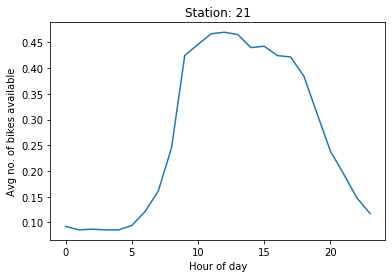

In [73]:
hour = [i for i in range(24)]
stationid = 21
plt.plot(hour, np.asarray(station_avg_availability[stationid]['bikes'])*station_avg_availability[stationid]['numbikestands'])
plt.xlabel('Hour of day')
plt.ylabel('Avg no. of bikes available')
plt.title('Station: ' + str(stationid))
plt.savefig('time_station'+str(stationid)+'.png',dpi=100)

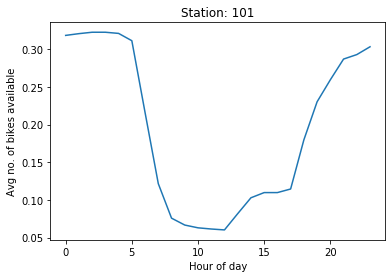

In [74]:
stationid = 101
plt.plot(hour, np.asarray(station_avg_availability[stationid]['bikes'])*station_avg_availability[stationid]['numbikestands'])
plt.xlabel('Hour of day')
plt.ylabel('Avg no. of bikes available')
plt.title('Station: ' + str(stationid))
plt.savefig('time_station'+str(stationid)+'.png',dpi=100)

In [75]:
weatherid_dummies = []
weatherid_means = []
for i,weatherid in enumerate(df['weatherid'].unique()):
    weatherid_dummies += [i]
    weatherid_means += [df_norm['availbikes'][df['weatherid'] == weatherid].mean()]
    print(i,weatherid)

0 500
1 803
2 520
3 501
4 310
5 802
6 300
7 801
8 521
9 804
10 502
11 800
12 741
13 701
14 311
15 301


In [76]:
df_norm['weatherid'].unique()

[500, 803, 520, 501, 310, ..., 800, 741, 701, 311, 301]
Length: 16
Categories (16, int64): [500, 803, 520, 501, ..., 741, 701, 311, 301]

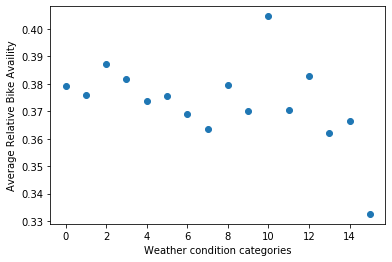

In [77]:
plt.plot(weatherid_dummies,weatherid_means,'o')
plt.ylabel('Average Relative Bike Availity')
plt.xlabel('Weather condition categories')
plt.savefig('availability_conditioncat.png',dpi=100)

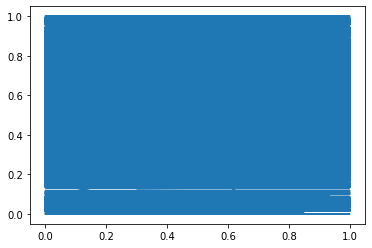

In [78]:
plt.plot(df_norm['availbikes'],df_norm['temp'])

In [79]:
sample = df_norm.sample(n=1000, random_state=1)

In [80]:
sample.describe().T

,count,mean,std,min,25%,50%,75%,max
availbikes,1000.0,0.366690,0.315080,0.000000,0.075000,0.300000,0.625000,1.0
numbikestands,1000.0,0.681417,0.321963,0.000000,0.541667,0.583333,1.000000,1.0
temp,1000.0,0.505706,0.208032,0.022911,0.351584,0.476752,0.638646,1.0
feels_like,1000.0,0.488264,0.198977,0.036496,0.331696,0.470241,0.638967,1.0
temp_min,1000.0,0.568808,0.196016,0.066627,0.433373,0.566627,0.686675,1.0
temp_max,1000.0,0.460085,0.205969,0.069252,0.307479,0.423130,0.615651,1.0
pressure,1000.0,0.603815,0.181261,0.018519,0.537037,0.629630,0.722222,1.0
humidity,1000.0,0.590813,0.192998,0.000000,0.479167,0.604167,0.708333,1.0
windspeed,1000.0,0.409846,0.194431,0.000000,0.307692,0.461538,0.538462,1.0
winddirection,1000.0,0.616712,0.142415,0.000000,0.593750,0.625000,0.718750,1.0


0.36075699038196274
0.33450398118394986


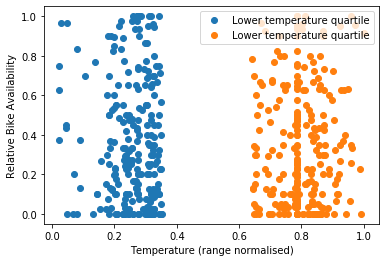

In [81]:
plt.plot(sample['temp'][sample['temp']<0.351584],sample['availbikes'][sample['temp']<0.351584],'o',label='Lower temperature quartile')
plt.plot(sample['temp'][sample['temp']>0.638967],sample['availbikes'][sample['temp']>0.638967],'o',label='Lower temperature quartile')
plt.xlabel('Temperature (range normalised)')
plt.ylabel('Relative Bike Availability')
plt.legend(loc='best')
plt.savefig('availability vs temperature')

print(sample['availbikes'][sample['temp']<0.351584].mean())
print(sample['availbikes'][sample['temp']>0.638967].mean())

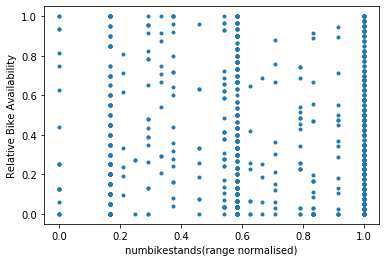

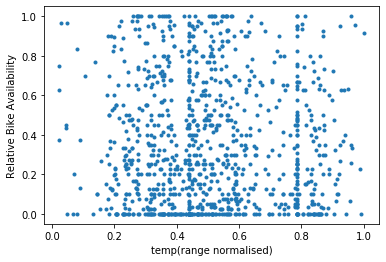

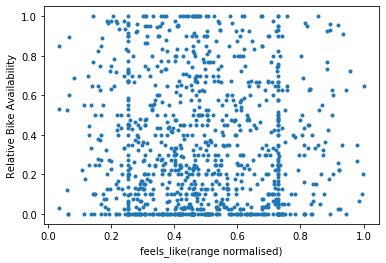

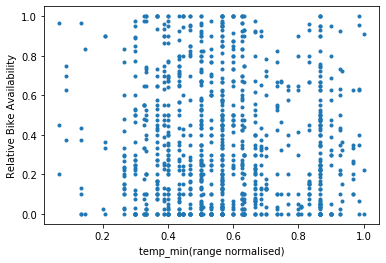

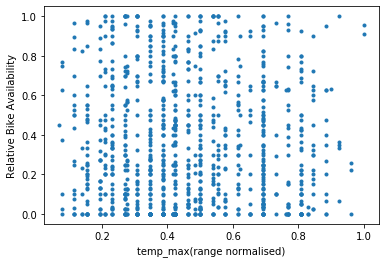

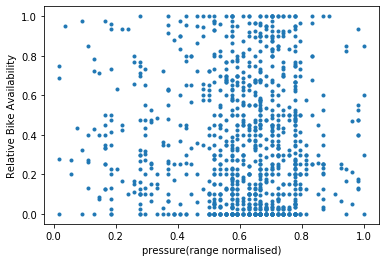

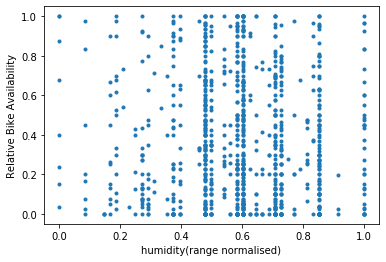

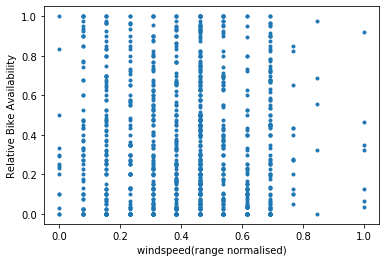

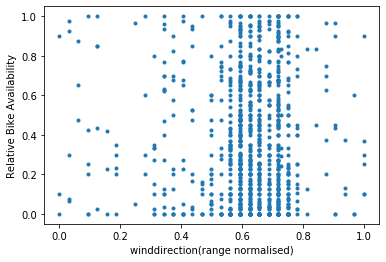

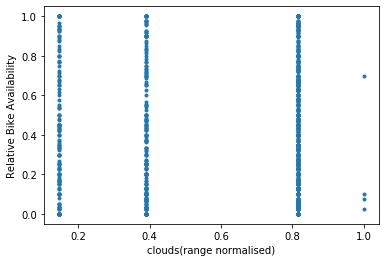

In [82]:
for feature in numeric_columns:
    plt.plot(sample[feature],sample['availbikes'],'.')
    plt.ylabel('Relative Bike Availability')
    plt.xlabel(feature + '(range normalised)')
    plt.show()

# Training Models

Next we train a model with the available data 

In [83]:
features = df.columns.values.tolist()
features

['ID',
 'availbikes',
 'status',
 'time',
 'banking',
 'numbikestands',
 'weatherid',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'windspeed',
 'winddirection',
 'clouds',
 'sunrise',
 'sunset',
 'hour',
 'weekday']

In [84]:
features.pop(0)
features.pop(0)
features.pop(1)
features

['status',
 'banking',
 'numbikestands',
 'weatherid',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'windspeed',
 'winddirection',
 'clouds',
 'sunrise',
 'sunset',
 'hour',
 'weekday']

In [85]:
station_dfs = dict()
for ID in df['ID'].unique():
    df_model = df[df['ID']==ID].copy().drop('time',axis=1)
    df_model = df_model.drop('ID',axis=1)
    df_model = df_model.reset_index().drop('index',axis=1)
    df_model = pd.get_dummies(df_model,drop_first=False)
    station_dfs[ID] = df_model

In [86]:
models = dict()
modelfeatures = station_dfs[2].columns.values.tolist()
modelfeatures.pop(0)
modelfeatures.pop(0)
for ID in station_dfs:
    X = station_dfs[ID][modelfeatures]
    y = station_dfs[ID]['availbikes']
    models[ID] = LinearRegression().fit(X, y)
X.head()

,temp,feels_like,temp_min,temp_max,pressure,humidity,windspeed,winddirection,clouds,sunrise,...,weatherid_802,weatherid_803,weatherid_804,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,277.65,268.83,277.04,278.15,1002.0,86.0,10.0,270.0,75.0,7,...,0,0,0,0,0,0,1,0,0,0
1,277.65,268.83,277.04,278.15,1002.0,86.0,10.0,270.0,75.0,7,...,0,0,0,0,0,0,1,0,0,0
2,277.76,268.61,277.15,278.15,1003.0,86.0,11.0,270.0,75.0,7,...,0,1,0,0,0,0,1,0,0,0
3,277.76,268.61,277.15,278.15,1003.0,86.0,11.0,270.0,75.0,7,...,0,1,0,0,0,0,1,0,0,0
4,277.76,268.61,277.15,278.15,1003.0,86.0,11.0,270.0,75.0,7,...,0,1,0,0,0,0,1,0,0,0


In [87]:
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

RMSEs = []
fractional_RMSEs = []
overall_RMSE = 0
modelsize_avg = 0
for ID in station_dfs:
    X = station_dfs[ID][modelfeatures]
    y = station_dfs[ID]['availbikes']
    prediction = models[ID].predict(X[modelfeatures])
    print("\nPredictions with multiple linear regression: \n")
    actual_vs_predicted_multiplelinreg = pd.concat([y, pd.DataFrame(prediction, columns=['Predicted'])], axis=1)
    print(actual_vs_predicted_multiplelinreg)
    printMetrics(y,prediction)
    RMSEs += [metrics.mean_squared_error(y, prediction)**0.5]
    fractional_RMSEs += [metrics.mean_squared_error(y, prediction)**0.5/station_numbikestands[ID]]
    overall_RMSE += (metrics.mean_squared_error(y, prediction)**0.5/station_numbikestands[ID])/len(station_numbikestands)
    modelsize_avg += X.shape[0]/len(station_numbikestands)
    
print()
print('Avg RMSE/numbikestands over all stands: %s'%overall_RMSE)
print('Average size of x: %.0f rows'%modelsize_avg)


Predictions with multiple linear regression: 

      availbikes  Predicted
0              4   9.305364
1              4   9.431649
2              4   9.691167
3              4  12.117657
4              4  12.117657
...          ...        ...
4201          14  20.492832
4202          15  28.798342
4203          15  28.734443
4204          15  29.611560
4205          15  28.840561

[4206 rows x 2 columns]

MAE:  6.309406499592652
MSE:  63.151707220898345
RMSE:  7.946804843514049
R2:  0.49659787048146486

Predictions with multiple linear regression: 

      availbikes  Predicted
0              2   3.142119
1              2   3.353164
2              2   3.738706
3              3   3.738706
4              4   6.979741
...          ...        ...
3584           0   9.324263
3585           0   8.741857
3586           0   8.741857
3587           0   8.637850
3588           0   7.757629

[3589 rows x 2 columns]

MAE:  4.068398895737387
MSE:  26.449454461873856
RMSE:  5.142903310570193
R2:  0.


      availbikes  Predicted
0             14  16.968318
1             14  17.080924
2             14  17.080924
3             13  17.080924
4             12  19.214951
...          ...        ...
3571          20  17.500266
3572          20  25.527163
3573          20  25.785676
3574          20  28.940301
3575          20  28.940301

[3576 rows x 2 columns]

MAE:  6.146536417464621
MSE:  57.65093501233994
RMSE:  7.59282128146975
R2:  0.4691518429226271

Predictions with multiple linear regression: 

      availbikes  Predicted
0             21  20.886686
1             15  20.434619
2             16  20.564545
3             16  20.564545
4             15  20.564545
...          ...        ...
4113          27  18.594731
4114          28  18.401327
4115          28  17.905159
4116          28  16.926717
4117          27  16.926717

[4118 rows x 2 columns]

MAE:  7.357377618633374
MSE:  84.40544901402166
RMSE:  9.187243820320742
R2:  0.2549611901173795

Predictions with multiple linear 


      availbikes  Predicted
0             19   4.883265
1             20   4.803740
2             20   4.631798
3             20   6.511713
4             20   6.511713
...          ...        ...
3553          10   5.716095
3554           9   7.605668
3555          10   7.486594
3556           9   6.211438
3557           9   6.211438

[3558 rows x 2 columns]

MAE:  3.8787900498172676
MSE:  22.912647786991936
RMSE:  4.78671576208489
R2:  0.46318762302587824

Predictions with multiple linear regression: 

      availbikes  Predicted
0              5   7.200816
1              5   7.320787
2              5   7.320787
3              4   6.726004
4              4   6.726004
...          ...        ...
3390          12  16.248133
3391          11  16.493674
3392          10  16.493674
3393          10  17.453753
3394          10  17.453753

[3395 rows x 2 columns]

MAE:  5.699991007879261
MSE:  44.98999892765643
RMSE:  6.707458455156948
R2:  0.2765919726510332

Predictions with multiple line

RMSE:  7.731610939378681
R2:  0.27335469610613106

Predictions with multiple linear regression: 

      availbikes  Predicted
0              9   4.615182
1             12   4.633755
2             11   4.633755
3             11   4.769045
4             11   4.769045
...          ...        ...
4061           4   2.447248
4062           4   3.327760
4063           4   3.332227
4064           4   3.487511
4065           4   3.487511

[4066 rows x 2 columns]

MAE:  2.5051464221204607
MSE:  10.626079761785745
RMSE:  3.2597668262907615
R2:  0.1742688082799373

Predictions with multiple linear regression: 

      availbikes  Predicted
0             14  15.871952
1             14  15.465720
2             14  15.465720
3             15  18.779388
4             15  18.779388
...          ...        ...
3654          28  17.372171
3655          29  17.372171
3656          30  17.658094
3657          30  18.596657
3658          30  18.596657

[3659 rows x 2 columns]

MAE:  6.5365930315665945
MSE: 

[3729 rows x 2 columns]

MAE:  6.8332379329941695
MSE:  68.89641897133211
RMSE:  8.300386676012877
R2:  0.3756728839064494

Predictions with multiple linear regression: 

      availbikes  Predicted
0              8  13.965158
1              8  13.965158
2              9  14.462304
3              8  14.462304
4              9  16.682944
...          ...        ...
4099          29  25.594317
4100          29  25.758585
4101          28  28.933581
4102          29  28.353490
4103          29  28.353490

[4104 rows x 2 columns]

MAE:  7.0739409882689905
MSE:  73.05832822382305
RMSE:  8.5474164648637
R2:  0.34394540134734275

Predictions with multiple linear regression: 

      availbikes  Predicted
0              0  11.305464
1              1  11.305464
2              0  11.263919
3              0  11.263919
4              0  10.284062
...          ...        ...
3336          24   9.876827
3337          24   7.940466
3338          24   7.940466
3339          24   8.048998
3340          

MAE:  3.7856582119789564
MSE:  22.020465596002012
RMSE:  4.69259689255342
R2:  0.4051504872183809

Predictions with multiple linear regression: 

      availbikes  Predicted
0              9  13.953858
1              8  14.349062
2              8  14.349062
3              8  14.349062
4              7  15.335364
...          ...        ...
4027          17  18.606122
4028          16  16.674935
4029          16  16.691170
4030          16  16.948431
4031          16  16.948431

[4032 rows x 2 columns]

MAE:  5.97595259966688
MSE:  52.573369551515945
RMSE:  7.250749585492244
R2:  0.24948191785277585

Predictions with multiple linear regression: 

      availbikes  Predicted
0             24  13.528902
1             25  13.235306
2             25  13.235306
3             24  10.967615
4             24  10.967615
...          ...        ...
3470          12   8.584526
3471          12   1.381444
3472          11   1.381444
3473          11   1.168140
3474          11  -2.026737

[3475 row


Predictions with multiple linear regression: 

      availbikes  Predicted
0              6  12.908314
1              6  13.754645
2              6  13.281732
3              6  13.281732
4              7  13.281732
...          ...        ...
3577          16  10.851350
3578          16  11.757276
3579          16  11.869234
3580          16  14.575822
3581          16  14.575822

[3582 rows x 2 columns]

MAE:  5.692788484932496
MSE:  51.17525372758088
RMSE:  7.153688120653631
R2:  0.35929140388428127

Predictions with multiple linear regression: 

      availbikes  Predicted
0             28  21.031795
1             28  20.644780
2             28  19.112565
3             28  19.112565
4             29  19.112565
...          ...        ...
3557           9  14.775486
3558           9  10.445108
3559           9  10.445108
3560          10  11.719918
3561          10  11.719918

[3562 rows x 2 columns]

MAE:  6.874532728265825
MSE:  70.60996607391216
RMSE:  8.402973644723168
R2:  0.25


Predictions with multiple linear regression: 

      availbikes  Predicted
0             22  13.210556
1             22  13.210556
2             22  10.030530
3             21  10.030530
4             21  10.030530
...          ...        ...
3494           0  10.943184
3495           0   2.862658
3496           0   2.584836
3497           0   1.542420
3498           0   1.542420

[3499 rows x 2 columns]

MAE:  6.567782271196881
MSE:  64.38889564161516
RMSE:  8.024269165576088
R2:  0.33180031458680304

Avg RMSE/numbikestands over all stands: 0.2271024457583264
Average size of x: 3655 rows


In [88]:
print(min(RMSEs))
print(max(RMSEs))
print(max(fractional_RMSEs))
print(min(fractional_RMSEs))


1.8142273160537534
12.34293349165961
0.3157302682863857
0.0873468841489956


## 70-30 Split Evaluation

In [89]:
RMSEs = []
fractional_RMSEs = []
overall_RMSE = 0
X_train_size_avg = 0
X_test_size_avg = 0

for ID in station_dfs:
    X = station_dfs[ID][modelfeatures]
    y = station_dfs[ID]['availbikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #add to avg size of train/test arrays
    X_train_size_avg += X_train.shape[0]/len(station_numbikestands)
    X_test_size_avg += X_test.shape[0]/len(station_numbikestands)
    
    model = LinearRegression().fit(X_train,y_train)
    prediction = models[ID].predict(X_test)
    actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(prediction, columns=['Predicted'])], axis=1)
    printMetrics(y_test, prediction)
    print()
    RMSEs += [metrics.mean_squared_error(y_test, prediction)**0.5]
    fractional_RMSEs += [metrics.mean_squared_error(y_test, prediction)**0.5/station_numbikestands[ID]]
    overall_RMSE += (metrics.mean_squared_error(y_test, prediction)**0.5/station_numbikestands[ID])/len(station_numbikestands)
print('Avg RMSE/numbikestands over all stands: %s'%overall_RMSE)
print('Avg train/test size: %.0f/%.0f'%(X_train_size_avg,X_test_size_avg))


MAE:  6.387172650135148
MSE:  63.91073375662069
RMSE:  7.99441891300554
R2:  0.499554093382654


MAE:  4.1078755382225465
MSE:  27.59683193339942
RMSE:  5.253268690386912
R2:  0.3354441856582052


MAE:  8.433210846694895
MSE:  107.30477391451805
RMSE:  10.358801760556963
R2:  0.2640166961304252


MAE:  3.6263473199284935
MSE:  20.97186126485094
RMSE:  4.5795044780905
R2:  0.40096776569047576


MAE:  6.968689051759288
MSE:  77.14434890775962
RMSE:  8.783185578579085
R2:  0.4943206970415881


MAE:  5.700594012900128
MSE:  48.055263000361784
RMSE:  6.93219034651832
R2:  0.44084055475288064


MAE:  2.7601298710237074
MSE:  12.503965224849743
RMSE:  3.536094628944444
R2:  0.4259977217912432


MAE:  7.035111914823386
MSE:  70.91970631618608
RMSE:  8.421383871798392
R2:  0.29017009373531233


MAE:  8.015102842665613
MSE:  94.94599506136417
RMSE:  9.74402355607601
R2:  0.34578636087152836


MAE:  7.932176685058483
MSE:  89.67249014498074
RMSE:  9.469555963453658
R2:  0.3248684476846412


MAE:

R2:  0.12683728778098535


MAE:  6.532439613837575
MSE:  66.28741736871595
RMSE:  8.141708504283113
R2:  0.34538586085488565


MAE:  9.520028421343776
MSE:  134.7190446130497
RMSE:  11.606853346753793
R2:  0.32395801897884546


MAE:  4.462916216799791
MSE:  31.257484786575414
RMSE:  5.5908393633313604
R2:  0.32863662076064337


MAE:  5.939369365088777
MSE:  53.93206531131011
RMSE:  7.343845403554606
R2:  0.4179586328311111


MAE:  4.456248546337899
MSE:  31.201248204674563
RMSE:  5.585807748631756
R2:  0.3363357765057603


MAE:  5.5132839201140555
MSE:  47.838348405928315
RMSE:  6.916527192596608
R2:  0.3566112779457975


MAE:  4.6541356315782005
MSE:  35.96192075295333
RMSE:  5.996825889831498
R2:  0.42853366874344734


MAE:  7.16555671981076
MSE:  74.94772351387847
RMSE:  8.657235327393987
R2:  0.28958622650106647


MAE:  7.8411133414180405
MSE:  95.89423713555887
RMSE:  9.792560295222025
R2:  0.4150430371579811


MAE:  2.5539375908561484
MSE:  10.514658281514407
RMSE:  3.24263138230

MAE:  6.98591483445623
MSE:  78.85706490126354
RMSE:  8.880150049479093
R2:  0.3932315433617306


MAE:  5.0273129843621485
MSE:  44.17557624542768
RMSE:  6.6464709617531375
R2:  0.2332692080575427


MAE:  5.036467327031091
MSE:  42.18213230105304
RMSE:  6.494777309581371
R2:  0.3010214777644219


MAE:  7.149858450945558
MSE:  81.79547790155922
RMSE:  9.044085244045371
R2:  0.4208141942759721


MAE:  6.9662799792133665
MSE:  73.69842223357945
RMSE:  8.584778519774371
R2:  0.22566828739123568


MAE:  8.950504015212333
MSE:  125.57573508170007
RMSE:  11.20605796351688
R2:  0.3444650291817549


MAE:  6.623735949940719
MSE:  65.08267028214372
RMSE:  8.067383112394237
R2:  0.3298865570399616

Avg RMSE/numbikestands over all stands: 0.2270715853857814
Avg train/test size: 2558/1097


# Conclusion

The final models described above have an average station-to-station RMSE of 22.7% which has been cross validated with a 70-30 test-train split, and was deemed sufficiently accurate to use as the predictive model for our application. 

# Exporting models using Pickle

In [ ]:
import pickle

for ID in models:
    with open('model_'+str(ID)+'.pkl','wb') as handle:
        pickle.dump(models[ID], handle, pickle.HIGHEST_PROTOCOL)

# Design of functions for retrieval of Model Predictions

What follows not any component of the model design, but rather elements of the design of the get_prediciton function used to extract predictions for use in the web application. The functions were tested in Jupyter for ease of access to the models in case of any neccesity to change any element of the models implementation while workign out these functions.

In [90]:
modelfeatures

['temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'windspeed',
 'winddirection',
 'clouds',
 'sunrise',
 'sunset',
 'hour',
 'status_CLOSED',
 'status_OPEN',
 'banking_False',
 'banking_True',
 'weatherid_300',
 'weatherid_301',
 'weatherid_310',
 'weatherid_311',
 'weatherid_500',
 'weatherid_501',
 'weatherid_502',
 'weatherid_520',
 'weatherid_521',
 'weatherid_531',
 'weatherid_612',
 'weatherid_701',
 'weatherid_741',
 'weatherid_800',
 'weatherid_801',
 'weatherid_802',
 'weatherid_803',
 'weatherid_804',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [91]:
import mysql.connector

def get_5day_forcast():
    """Scrapes weather data from openweathermap.org"""
    
    API_KEY = "16fb93e92d3bd8aefd9b647c1a8f6acf"
    URL = "http://api.openweathermap.org/data/2.5/forecast?q=Dublin,ie&appid=" + API_KEY
    
#     time = get_datetime()
    try:
        r = requests.get(url = URL)
    except: 
        print("Scraping error: data not collected.")
        exit(1)
    
    dublin_data = r.json()
    return dublin_data

def get_current_station_data(id):
    try:
        # Connect to the RDS database
        mydb = mysql.connector.connect(
            host="dublin-bikes.cy2mnwcfkfbs.eu-west-1.rds.amazonaws.com",
            user="admin",
            passwd=PASSWD,
            database="dublinbikes"
        )

        mycursor = mydb.cursor()
        # called mysql stored procedure giving id as an argument
        mycursor.callproc('get_stand_info_by_id', [id, ])
        result = mycursor.stored_results()

    except mysql.connector.Error as err:

        print("SOMETHING WENT WRONG:", err)

# create empty array
    data = []

# iterate through results of mysql stored procedure and append to array
    for result in mycursor.stored_results():
        for row in result.fetchall():
            data.append({'id': row[0],
                            'availstands': row[1],
                            'availbikes': row[2],
                            'status': row[3],
                            'time': str(row[4]),
                            'banking': row[5],
                            'bonus': row[6],
                            'numbikestands': row[7],
                            })

    mycursor.close()
    mydb.close()

    return data

def get_locations():
    sql_statement = ("select * FROM staticinfo")

    try:
        # Connect to the RDS database
        mydb = mysql.connector.connect(
            host="dublin-bikes.cy2mnwcfkfbs.eu-west-1.rds.amazonaws.com",
            user="admin",
            passwd=PASSWD,
            database="dublinbikes"
        )

        mycursor = mydb.cursor()
        mycursor.execute(sql_statement)

        print(mycursor)
    except mysql.connector.Error as err:

        print("SOMETHING WENT WRONG:", err)

    data = []
    for row in mycursor:
        data.append({'id': row[0],
                    'name': row[2],
                    'lat': row[3],
                    'lon': row[4]})
    mycursor.close()
    mydb.close()

    return data
        
def get_forecast(ID):
    weather_conditions = ['weatherid_300', 
                          'weatherid_301',
                          'weatherid_310', 
                          'weatherid_311', 
                          'weatherid_500', 
                          'weatherid_501', 
                          'weatherid_502', 
                          'weatherid_520', 
                          'weatherid_521', 
                          'weatherid_531', 
                          'weatherid_612', 
                          'weatherid_701', 
                          'weatherid_741', 
                          'weatherid_800', 
                          'weatherid_801', 
                          'weatherid_802', 
                          'weatherid_803', 
                          'weatherid_804', 
                         ]
    all_station_data = get_current_station_data(ID)
    for station in all_station_data:
        if station['id'] == ID:
            station_data = station
            break
    dublin_data = get_5day_forcast()
    forecasts = dict()
    for prediction in dublin_data['list']:
        forecast = {
            'temp':prediction['main']['temp'],
            'feels_like':prediction['main']['feels_like'],
            'temp_min':prediction['main']['temp_min'],
            'temp_max':prediction['main']['temp_max'],
            'pressure':prediction['main']['pressure'],
            'humidity':prediction['main']['humidity'],
            'windspeed':prediction['wind']['speed'],
            'winddirection':prediction['wind']['deg'],
            'clouds':prediction['clouds']['all'],
            'sunrise':datetime.datetime.fromtimestamp(dublin_data['city']['sunrise']).hour,
            'sunset':datetime.datetime.fromtimestamp(dublin_data['city']['sunset']).hour,
            'hour':datetime.datetime.fromtimestamp(prediction['dt']).hour
        }
        if datetime.datetime.fromtimestamp(prediction['dt']).hour < 5:
            if datetime.datetime.fromtimestamp(prediction['dt']).hour == 0 and datetime.datetime.fromtimestamp(prediction['dt']).minute > 30:
                forecast['status_CLOSED'] = 1
                forecast['status_OPEN'] = 0
            elif datetime.datetime.fromtimestamp(prediction['dt']).hour > 0:
                forecast['status_CLOSED'] = 1
                forecast['status_OPEN'] = 0
        else: 
            forecast['status_CLOSED'] = 0
            forecast['status_OPEN'] = 1
        if station_data['banking'] == 'False':
            forecast['banking_False'] = 1
            forecast['banking_True'] = 0
        if station_data['banking'] == 'True':
            forecast['banking_False'] = 0
            forecast['banking_True'] = 1
        for condition in weather_conditions:
            if 'weatherid_' + str(prediction['weather'][0]['id']) == condition:
                forecast[condition] = 1
            else:
                forecast[condition] = 0 
        for i in range(7):
            if datetime.datetime.fromtimestamp(prediction['dt']).weekday() == i:
                forecast['weekday_'+str(i)] = 1
            else:
                forecast['weekday_'+str(i)] = 0
        days_from_today = (datetime.datetime.fromtimestamp(prediction['dt']).date() - datetime.datetime.today().date()).days
        forecasts[(ID,forecast['hour'],days_from_today)] = forecast
    return forecasts

In [92]:
forecast = get_forecast(2)
forecast

{(2, 19, 0): {'temp': 283.36,
  'feels_like': 278.52,
  'temp_min': 283.36,
  'temp_max': 283.49,
  'pressure': 1014,
  'humidity': 81,
  'windspeed': 5.95,
  'winddirection': 76,
  'clouds': 78,
  'sunrise': 6,
  'sunset': 20,
  'hour': 19,
  'status_CLOSED': 0,
  'status_OPEN': 1,
  'banking_False': 0,
  'banking_True': 1,
  'weatherid_300': 0,
  'weatherid_301': 0,
  'weatherid_310': 0,
  'weatherid_311': 0,
  'weatherid_500': 1,
  'weatherid_501': 0,
  'weatherid_502': 0,
  'weatherid_520': 0,
  'weatherid_521': 0,
  'weatherid_531': 0,
  'weatherid_612': 0,
  'weatherid_701': 0,
  'weatherid_741': 0,
  'weatherid_800': 0,
  'weatherid_801': 0,
  'weatherid_802': 0,
  'weatherid_803': 0,
  'weatherid_804': 0,
  'weekday_0': 0,
  'weekday_1': 0,
  'weekday_2': 0,
  'weekday_3': 0,
  'weekday_4': 1,
  'weekday_5': 0,
  'weekday_6': 0},
 (2, 22, 0): {'temp': 282.41,
  'feels_like': 276.96,
  'temp_min': 282.41,
  'temp_max': 282.51,
  'pressure': 1015,
  'humidity': 90,
  'windspeed':

In [97]:
IDs = df['ID'].unique()

def get_station_forcasts(models):
    IDs = [38, 16, 36, 12, 113, 45, 2, 34, 56, 44, 104, 89, 87, 9, 29, 88, 66,
       62, 57, 103, 77, 106, 32, 79, 17, 114, 102, 33, 27, 4, 7, 64, 41,
       84, 37, 49, 107, 22, 69, 58, 3, 100, 48, 83, 94, 11, 39, 75, 90,
       61, 13, 96, 91, 72, 101, 65, 6, 109, 55, 53, 115, 24, 112, 42, 73,
       30, 26, 92, 71, 93, 19, 97, 40, 15, 10, 28, 68, 31, 23, 99, 63, 98,
       8, 5, 86, 43, 110, 108, 50, 105, 76, 52, 74, 80, 59, 78, 117, 82,
       51, 85, 21, 81, 95, 18, 54, 111, 67, 47, 25]
    stationforcasts = dict()
    for ID in IDs:
        forecast = get_forecast(ID)
        station = {
            0:dict(),
            1:dict(),
            2:dict(),
            3:dict(),
            4:dict(),
            5:dict()
        }
        for key in forecast:
            for i in range(3):
                hour = key[1] + i
                day = key[2]
                if hour > 23:
                    day += 1
                    hour -= 24
                station[day][hour] = forecast[key]
                station[day][hour]['hour'] = hour
                station[day][hour] = np.array([value for value in forecast[key].values()])
                X = station[day][hour].reshape(1, -1) 
                y = models[ID].predict(X)
                station[day][hour] = int(round(y[0]))
        stationforcasts[ID] = station
    return stationforcasts
        
stationforcast = get_station_forcasts(models)

In [101]:
stationforcast

{38: {0: {19: 13, 20: 13, 21: 13, 22: 11, 23: 11},
  1: {0: 8,
   1: 24,
   2: 24,
   3: 25,
   4: 26,
   5: 26,
   6: 26,
   7: 26,
   8: 26,
   9: 26,
   10: 31,
   11: 31,
   12: 31,
   13: 31,
   14: 31,
   15: 31,
   16: 27,
   17: 28,
   18: 28,
   19: 29,
   20: 29,
   21: 30,
   22: 34,
   23: 35},
  2: {0: 32,
   1: 30,
   2: 30,
   3: 30,
   4: 31,
   5: 31,
   6: 31,
   7: 31,
   8: 31,
   9: 32,
   10: 25,
   11: 25,
   12: 26,
   13: 28,
   14: 28,
   15: 28,
   16: 28,
   17: 29,
   18: 29,
   19: 31,
   20: 31,
   21: 31,
   22: 34,
   23: 34},
  3: {0: 31,
   1: 18,
   2: 18,
   3: 19,
   4: 13,
   5: 13,
   6: 13,
   7: 10,
   8: 10,
   9: 11,
   10: 6,
   11: 6,
   12: 6,
   13: 5,
   14: 5,
   15: 5,
   16: 3,
   17: 3,
   18: 3,
   19: 5,
   20: 5,
   21: 5,
   22: 6,
   23: 6},
  4: {0: 4,
   1: 8,
   2: 8,
   3: 8,
   4: 9,
   5: 9,
   6: 10,
   7: 14,
   8: 14,
   9: 14,
   10: 13,
   11: 14,
   12: 14,
   13: 11,
   14: 11,
   15: 11,
   16: 6,
   17: 6,
   18: 

# Experiment with periodic times

An investigation was made into improving the model by converting the time features to a sinosoidal representation cosidering the cyclic effect of the time of day on availability. It was found that such a representation resulted in a reduction in the root-mean-squared error by over 3%. The attempt was abandoned however due to difficulties in rejigging the function for retrieving a prediction with the new models. This problem could have been readily enough solved with enough time, however it was decided to prioritise interfacing the models with the application in general to have a viable product, and time was not found to further improve the model due to general bug fixing and working on the project report.

What follows can be neglected as it did not culminate in influencing any feature of the product, however it does illutsrate one step we would take to improve model performance given more time

In [ ]:
df_weather = df_weather.rename(columns={'dt':'time'})

df_bikes_sorted = df_bikes.sort_values(by=['time'])
df_weather_sorted = df_weather.sort_values(by=['time'])

df = pd.merge_asof(df_bikes_sorted, df_weather_sorted, on='time')

In [ ]:
df_weather = df_weather.rename(columns={'dt':'time'})

df_bikes_sorted = df_bikes.sort_values(by=['time'])
df_weather_sorted = df_weather.sort_values(by=['time'])

df = pd.merge_asof(df_bikes_sorted, df_weather_sorted, on='time')

In [ ]:
df.shape

In [ ]:
df.head()

We can see a large number of rows with NaN weather data due to the bikes data scraping beginning prior to scraping weather data. We drop rows with NaN weather data:

In [ ]:
df = df[df['weatherid'].notnull()]

We were instucted to only use data prior to the goverment-imposed restrictions as a result of the COVID-19 pandemic - as such we drop all rows with dates following the beginning of restrictions on March 12th.

In [ ]:
#Dropping table entries post-Covid-19 Measures
df = df[df['time'] < datetime.datetime(year=2020,month=3,day=12)]

Restricting the data to before March 12th also means restricting data to before the beginning of dalight savings time - as a result the timezone feature will now have a cardinality of 1 and can be dropped.

In [ ]:
df.shape

In [ ]:
df['timezone'].unique()

In [ ]:
df = df.drop('timezone',axis=1)

In [ ]:
df.head()

In [ ]:
cont_features = ['temp','feels_like','temp_min','temp_max','pressure','humidity','windspeed','winddirection','clouds']

# Additional Features

It is necessary to add a few additional features to analyse the data based on time considering the unwieldly datetime info availiable.

- sunrise, sunset, and time will now be replaced by the hour of the day in which sunrise and sunset occur
- an additional hour feature will be added to represent the hour of the data for a row, and a feature indicating the day of the week will be added

In [ ]:
df['weekday'] = df['time'].dt.weekday.astype('category')
df['time'] = df['time'].dt.hour*60*60 + df['time'].dt.minute*60 + df['time'].dt.second
df['sunrise'] = df['sunrise'].dt.hour*60*60 + df['sunrise'].dt.minute*60 + df['sunrise'].dt.second
df['sunset'] = df['sunset'].dt.hour*60*60 + df['sunset'].dt.minute*60 + df['sunset'].dt.second
# df['weekday'] = df['time'].dt.weekday.astype('category')

In [ ]:
# Add sine and cosine of hour columns to account for periodicity of time of day
df['timecos'] = np.cos(2*np.pi*df['time']/(60*60*24))
df['timesin'] = np.sin(2*np.pi*df['time']/(60*60*24))
df['sunrisecos'] = np.cos(2*np.pi*df['sunrise']/(60*60*24))
df['sunrisesin'] = np.sin(2*np.pi*df['sunrise']/(60*60*24))
df['sunsetcos'] = np.cos(2*np.pi*df['sunset']/(60*60*24))
df['sunsetsin'] = np.sin(2*np.pi*df['sunset']/(60*60*24))

# df=df.drop('time',axis=1)
df=df.drop('sunrise',axis=1)
df=df.drop('sunset',axis=1)

In [ ]:
df.head()

In [ ]:
sample = df[df['ID']==2].sample(n=100, random_state=1)

In [ ]:
for feature in cont_features:
    plt.plot(sample[feature],sample['availbikes'],'.')
    plt.xlabel(feature)
    plt.show()

In [ ]:
features = df.columns.values.tolist()
# features.pop(0)
# features.pop(0)
# features.pop(0)
features

In [ ]:
IDs = [id for id in df['ID'].unique()]
features.pop(0)
features.pop(0)
features.pop(1)

In [ ]:
models = dict()
for ID in IDs:
    df_model = df_model
    df_model = df_model.reset_index().drop('index',axis=1)
    df_model = pd.get_dummies(df_model,drop_first=False)
    modelfeatures = df_model.columns.values.tolist()
    modelfeatures.pop(0)
    X = df_model[modelfeatures]
    y = df_model['availbikes']
    models[ID] = LinearRegression().fit(X, y)

In [ ]:
station_dfs = dict()
for ID in IDs:
    df_model = df[df['ID']==ID].copy()#.drop('time',axis=1)
    df_model = df_model.drop('ID',axis=1)
    df_model = df_model.reset_index().drop('index',axis=1)
    df_model = pd.get_dummies(df_model,drop_first=False)
    station_dfs[ID] = df_model

In [ ]:
modelfeatures = station_dfs[2].columns.values.tolist()
modelfeatures.pop(0)
modelfeatures.pop(0)
for ID in station_dfs:
#     modelfeatures = station_dfs[ID].columns.values.tolist()
#     modelfeatures.pop(0)
    X = station_dfs[ID][modelfeatures]
    y = station_dfs[ID]['availbikes']
    models[ID] = LinearRegression().fit(X, y)

In [ ]:
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

# def overallMetrics(testActualVal, predictions):
#     #classification evaluation measures
#     print('\n==============================================================================')
#     print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
#     print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
#     print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
#     print("R2: ", metrics.r2_score(testActualVal, predictions))

overall_RMSE = 0
for ID in station_dfs:
#     modelfeatures = station_dfs[ID].columns.values.tolist()
#     modelfeatures.pop(0)
    X = station_dfs[ID][modelfeatures]
    y = station_dfs[ID]['availbikes']
    prediction = models[ID].predict(X[modelfeatures])
    print("\nPredictions with multiple linear regression: \n")
    actual_vs_predicted_multiplelinreg = pd.concat([y, pd.DataFrame(prediction, columns=['Predicted'])], axis=1)
    print(actual_vs_predicted_multiplelinreg)
    printMetrics(y,prediction)
    overall_RMSE += (metrics.mean_squared_error(y, prediction)**0.5/station_numbikestands[ID])/len(station_numbikestands)
    
print()
print('Avg RMSE/numbikestands over all stands: %s'%overall_RMSE)

We find that the models using a sinosoidal representation of the time features have an improved RMSE. 

In [ ]:
modelfeatures

In [ ]:
import mysql.connector

def get_5day_forcast():
    """Scrapes weather data from openweathermap.org"""
    
    API_KEY = "16fb93e92d3bd8aefd9b647c1a8f6acf"
    URL = "http://api.openweathermap.org/data/2.5/forecast?q=Dublin,ie&appid=" + API_KEY
    
#     time = get_datetime()
    try:
        r = requests.get(url = URL)
    except: 
        print("Scraping error: data not collected.")
        exit(1)
    
    dublin_data = r.json()
    return dublin_data

def get_current_station_data(id):
    try:
        # Connect to the RDS database
        mydb = mysql.connector.connect(
            host=URI,
            user=USER,
            passwd=PASSWD,
            database=DB
        )

        mycursor = mydb.cursor()
        # called mysql stored procedure giving id as an argument
        mycursor.callproc('get_stand_info_by_id', [id, ])
        result = mycursor.stored_results()

    except mysql.connector.Error as err:

        print("SOMETHING WENT WRONG:", err)

# create empty array
    data = []

# iterate through results of mysql stored procedure and append to array
    for result in mycursor.stored_results():
        for row in result.fetchall():
            data.append({'id': row[0],
                            'availstands': row[1],
                            'availbikes': row[2],
                            'status': row[3],
                            'time': str(row[4]),
                            'banking': row[5],
                            'bonus': row[6],
                            'numbikestands': row[7],
                            })

    mycursor.close()
    mydb.close()

    return data

def get_locations():
    sql_statement = ("select * FROM staticinfo")

    try:
        # Connect to the RDS database
        mydb = mysql.connector.connect(
            host=URI,
            user=USER,
            passwd=PASSWD,
            database=DB
        )

        mycursor = mydb.cursor()
        mycursor.execute(sql_statement)

        print(mycursor)
    except mysql.connector.Error as err:

        print("SOMETHING WENT WRONG:", err)

    data = []
    for row in mycursor:
        data.append({'id': row[0],
                    'name': row[2],
                    'lat': row[3],
                    'lon': row[4]})
    mycursor.close()
    mydb.close()

    return data
        
def get_forecast(ID):
    weather_conditions = ['weatherid_300', 
                          'weatherid_301',
                          'weatherid_310', 
                          'weatherid_311', 
                          'weatherid_500', 
                          'weatherid_501', 
                          'weatherid_502', 
                          'weatherid_520', 
                          'weatherid_521', 
                          'weatherid_531', 
                          'weatherid_612', 
                          'weatherid_701', 
                          'weatherid_741', 
                          'weatherid_800', 
                          'weatherid_801', 
                          'weatherid_802', 
                          'weatherid_803', 
                          'weatherid_804', 
                         ]
    all_station_data = get_current_station_data(ID)
    for station in all_station_data:
        if station['id'] == ID:
            station_data = station
            break
    dublin_data = get_5day_forcast()
    forecasts = dict()
    for prediction in dublin_data['list']:
        forecast = {
            'temp':prediction['main']['temp'],
            'feels_like':prediction['main']['feels_like'],
            'temp_min':prediction['main']['temp_min'],
            'temp_max':prediction['main']['temp_max'],
            'pressure':prediction['main']['pressure'],
            'humidity':prediction['main']['humidity'],
            'windspeed':prediction['wind']['speed'],
            'winddirection':prediction['wind']['deg'],
            'clouds':prediction['clouds']['all'],
            'sunrisecos':datetime.datetime.fromtimestamp(dublin_data['city']['sunrise']),
            'sunrisesin':datetime.datetime.fromtimestamp(dublin_data['city']['sunrise']),
            'sunsetcos':datetime.datetime.fromtimestamp(dublin_data['city']['sunset']),
            'sunsetsin':datetime.datetime.fromtimestamp(dublin_data['city']['sunset']),
            'timecos':datetime.datetime.fromtimestamp(prediction['dt']),
            'timesin':datetime.datetime.fromtimestamp(prediction['dt'])
        }
        if station_data['status'] == 'CLOSED':
            forecast['status_CLOSED'] = 1
            forecast['status_OPEN'] = 0
        if station_data['status'] == 'OPEN':
            forecast['status_CLOSED'] = 0
            forecast['status_OPEN'] = 1
        if station_data['banking'] == 'False':
            forecast['banking_False'] = 1
            forecast['banking_True'] = 0
        if station_data['banking'] == 'True':
            forecast['banking_False'] = 0
            forecast['banking_True'] = 1
        for condition in weather_conditions:
            if 'weatherid_' + str(prediction['weather'][0]['id']) == condition:
                forecast[condition] = 1
            else:
                forecast[condition] = 0 
        for i in range(7):
            if datetime.datetime.fromtimestamp(prediction['dt']).weekday() == i:
                forecast['weekday_'+str(i)] = 1
            else:
                forecast['weekday_'+str(i)] = 0
        days_from_today = (datetime.datetime.fromtimestamp(prediction['dt']).date() - datetime.datetime.today().date()).days
        forecasts[(ID,forecast['hour'],days_from_today)] = forecast
    return forecasts

In [ ]:
forecast = get_forecast(2)
forecast

In [ ]:
IDs = df['ID'].unique()

def get_station_forcasts(models):
    IDs = [38, 16, 36, 12, 113, 45, 2, 34, 56, 44, 104, 89, 87, 9, 29, 88, 66,
       62, 57, 103, 77, 106, 32, 79, 17, 114, 102, 33, 27, 4, 7, 64, 41,
       84, 37, 49, 107, 22, 69, 58, 3, 100, 48, 83, 94, 11, 39, 75, 90,
       61, 13, 96, 91, 72, 101, 65, 6, 109, 55, 53, 115, 24, 112, 42, 73,
       30, 26, 92, 71, 93, 19, 97, 40, 15, 10, 28, 68, 31, 23, 99, 63, 98,
       8, 5, 86, 43, 110, 108, 50, 105, 76, 52, 74, 80, 59, 78, 117, 82,
       51, 85, 21, 81, 95, 18, 54, 111, 67, 47, 25]
    stationforcasts = dict()
    for ID in IDs:
        forecast = get_forecast(ID)
        station = {
            0:dict(),
            1:dict(),
            2:dict(),
            3:dict(),
            4:dict(),
            5:dict()
        }
        for key in forecast:
            for i in range(3):
                hour = key[1] + i
                day = key[2]
                if hour > 23:
                    day += 1
                    hour -= 24
                station[day][hour] = forecast[key]
                station[day][hour]['timecos'] = hour
                station[day][hour] = np.array([value for value in forecast[key].values()])
                X = station[day][hour].reshape(1, -1) 
                y = models[ID].predict(X)
                station[day][hour] = int(round(y[0]))
        stationforcasts[ID] = station
    return stationforcasts
        
stationforcasts = get_station_forcasts(models)

In [ ]:
stationforcasts[38]

In [ ]:
X = dict()
for ID in stationforcast:
    for day in stationforcast[ID]:
        for hour in stationforcast[ID][day]:
            X = stationforcast[ID][day][hour].reshape(1, -1) 
            y = models[ID].predict(X)
            stationforcast[ID][day][hour] = int(round(y[0]))

In [ ]:
for ID in stationforcast:
    for day in stationforcast[ID]:
        for hour in stationforcast[ID][day]:
            stationforcast[ID][day][hour] = int(round(stationforcast[ID][day][hour]))

In [ ]:
stationforcast